# Transfer stylu


Celem projektu jest stworzenie algorytmu realizującego problem przeniesienia stylu między dwoma obrazami cyfrowymi z wykorzystaniem sieci głębokich.

In [1]:
# required libraries 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools


import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

import IPython.display

In [2]:
# global variables 
# input/output images
input_dir = './input/'
output_dir = './output/'
output_format = '.png'

content_path = ''
style_path = ''

# number of iterations
iter_num = 100

# image and loss vals logging interval (between iterations)
log_int = iter_num/10

### I. Wczytywanie oraz wizualizacja danych

Wczytywanie obrazu z dysku

In [3]:
# load image from disc and perform preprocessing
# return image as 4dim array of pixels (3 color levels)
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

    img = kp_image.img_to_array(img)

    img = np.expand_dims(img, axis=0)
    
    return img

Wyświetlanie obrazu

In [4]:
# print image (array of pixels form)
def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

### II. Wstępne przygotowywanie danych

Wczytanie ze wstępnym przetworzeniem pod kątem modelu sieci VGG19.
* Zmiana kolejności warst z RGB na BGR.
* Normalizacja pikseli kazdej warstwy poprzez odjęcie od wartości pikseli danej warstwy, średniej wartości pikseli dla tej warstwy w zbiorze treningowym sieci VGG19.

In [5]:
# load and perform preprocessing according to vgg19 requirements
# return preprocessed image (array of pixels format)
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

Denormalizacja przetworzobego obrazu.

In [6]:
# denormalize image (array of pixels form)
# return image as array of pixels
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

Wyznaczenie warst pośrednich modelu VGG19, które posłużą do budowy nowego modelu realizującego transfer stylu.

In [7]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### III. Zbudowanie nowego modelu realizującego transfer stylu

In [8]:
# load pretrained vgg model, pull out activation layers responsible for feature detection, create new model
# return new model based on pulled out vgg19 layers
def get_model():
    # Load VGG, pretrained model
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    # Build model 
    return models.Model(vgg.input, model_outputs)

### IV. Funkcje strat (kosztu)

Funckje odpowiadające za określenie dystansu określającego stopień różności dwóch obrazów w postaci tablicy pikseli.

**Content Loss**

In [9]:
# determine content loss value
# return loss value for content image and target image
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

**Style Loss**

In [10]:
# TODO
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [11]:
# determine style loss value
# return loss value for style image and target image
def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

### V. Optymalizacja modelu

Pozyskanie map cech dla obrazów content_image oraz style_image.

In [12]:
# load style and content image, builds model based on them, retrieve feature maps and list them
# returns lists of features for style and content images
def get_feature_representations(model, content_path, style_path):
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

Określenie w jakim stopniu obraz wyjściowy (target) różni sie od obrazów content_image oraz style_image.

In [13]:
# compute style and content loss values for provided feature maps
# return total loss, style loss and content loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    # Feed our init image through our model.
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

Wyliczenie gradientów dla obrazu wyjściowego.

In [14]:
# compute the gradiends
# return TODO
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

Funkcja optymalizująca model

In [15]:
# performs style transfer updating target images according to loss values of loaded content and style images
# prints updated target image and loss values for selected interval
# return image with best loss and best loss value
def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2, log_interval = None): 
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false. 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False

    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    
    # Create optimizer
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    # For displaying intermediate images 
    iter_count = 1

    # Store best result
    best_loss, best_img = float('inf'), None

    # Create config 
    loss_weights = (style_weight, content_weight)
    cfg = {
    'model': model,
    'loss_weights': loss_weights,
    'init_image': init_image,
    'gram_style_features': gram_style_features,
    'content_features': content_features
    }
    
    # For displaying
    num_rows = 2
    num_cols = 5

    if log_interval is None:
        display_interval = num_iterations/(num_rows*num_cols)
        #display_interval = 100
    else:
        display_interval = log_interval
        
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    imgs = []
    sum_time = 0
    sum_time_all = 0
    
    for i in range(num_iterations):
        start_time = time.time()
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()
        sum_time = sum_time + end_time - start_time
        sum_time_all = sum_time_all + end_time - start_time

        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval == 0:
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.display_png(Image.fromarray(plot_img))
            
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'avg iteration time: {:.4f}s'.format(loss, style_score, content_score, sum_time/display_interval))
            
            sum_time = 0

    print('Total time: {:.4f}s'.format(time.time() - global_start))
    print('Iteration avarage time: {:.4f}s'.format(sum_time_all/num_iterations))

    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss

### VI. Przeprowadzenie transferu stylu

Wyświetlenie obrazów reprezentujących styl oraz kopozycję.

In [16]:
# print best target, content and style images
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path) 
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()


Uruchomienie algorytmu

In [17]:
def display_content_and_style_img(content_path=None, style_path=None):  
    # content and style files locations
    content_path = 'img_dir/oryginal.jpg' if content_path is None else content_path
    style_path = 'img_dir/art.jpg' if style_path is None else style_path

    plt.figure(figsize=(10,10))

    # load images
    content = load_img(content_path).astype('uint8')
    style = load_img(style_path).astype('uint8')

    # print images
    print("Imput images")

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')
    plt.show()

Imput images


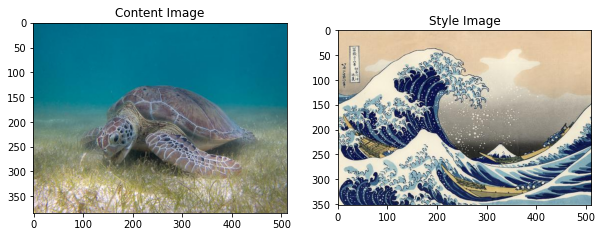

Processing images


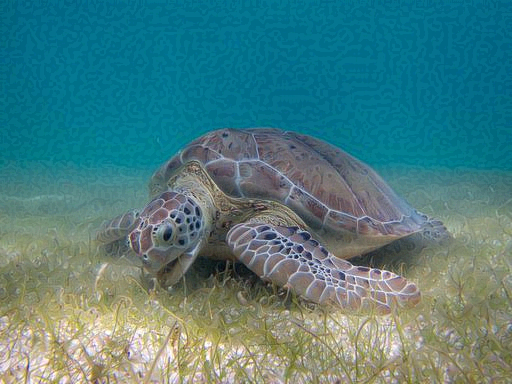

Iteration: 0
Total loss: 5.2974e+08, style loss: 5.2974e+08, content loss: 0.0000e+00, avg iteration time: 0.2883s


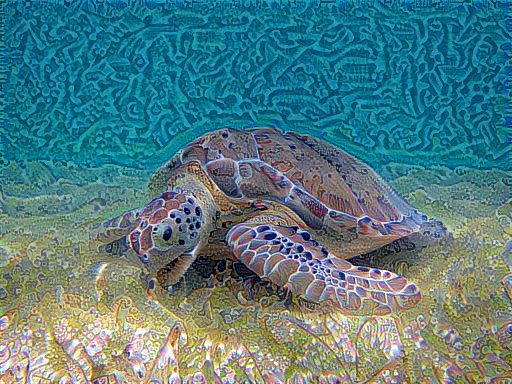

Iteration: 10
Total loss: 9.7749e+07, style loss: 9.6006e+07, content loss: 1.7429e+06, avg iteration time: 2.8663s


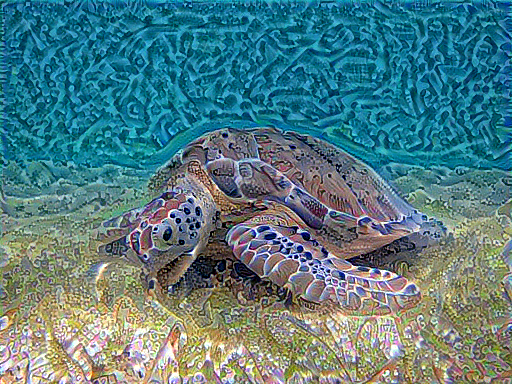

Iteration: 20
Total loss: 5.4015e+07, style loss: 5.2272e+07, content loss: 1.7428e+06, avg iteration time: 2.9245s


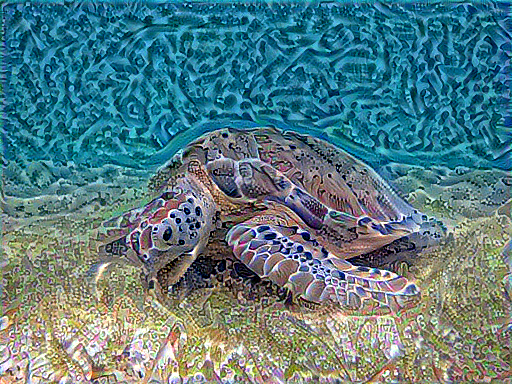

Iteration: 30
Total loss: 4.0107e+07, style loss: 3.8392e+07, content loss: 1.7148e+06, avg iteration time: 2.9092s


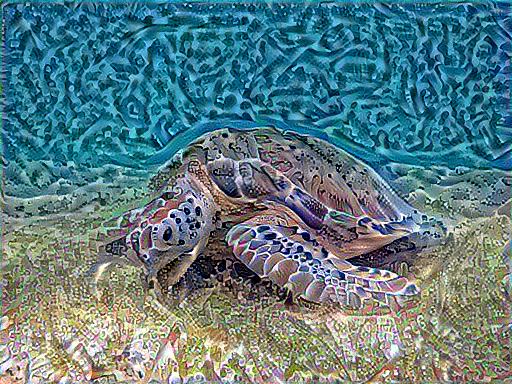

Iteration: 40
Total loss: 3.3377e+07, style loss: 3.1669e+07, content loss: 1.7081e+06, avg iteration time: 2.7554s


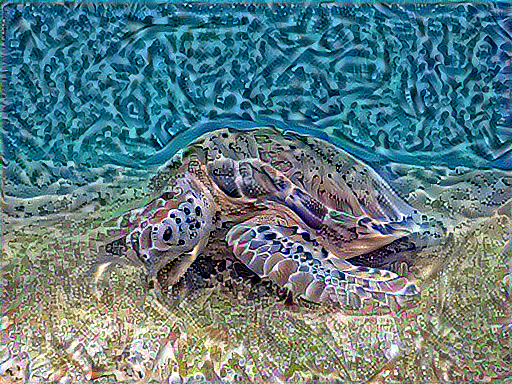

Iteration: 50
Total loss: 2.9002e+07, style loss: 2.7285e+07, content loss: 1.7173e+06, avg iteration time: 2.7353s


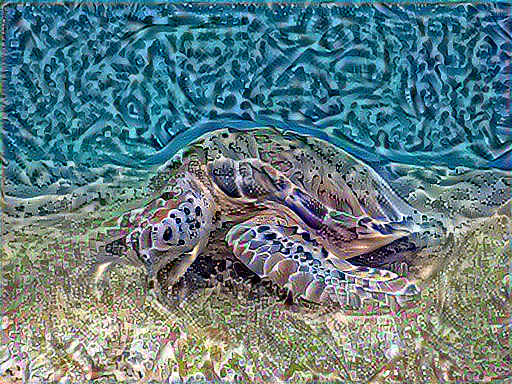

Iteration: 60
Total loss: 2.5562e+07, style loss: 2.3887e+07, content loss: 1.6747e+06, avg iteration time: 2.7882s


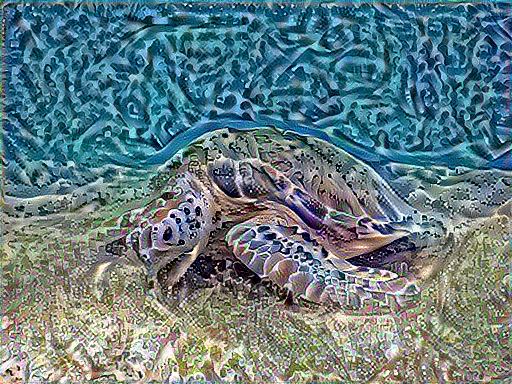

Iteration: 70
Total loss: 2.2758e+07, style loss: 2.1106e+07, content loss: 1.6520e+06, avg iteration time: 2.7787s


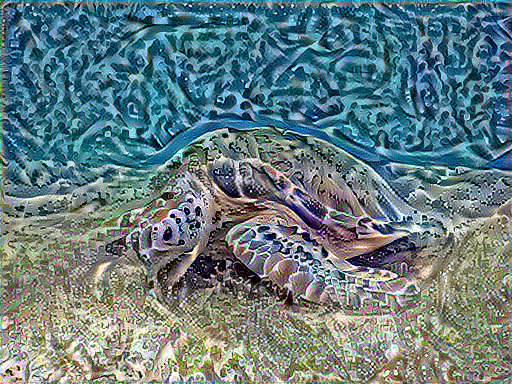

Iteration: 80
Total loss: 2.0397e+07, style loss: 1.8758e+07, content loss: 1.6386e+06, avg iteration time: 2.7807s


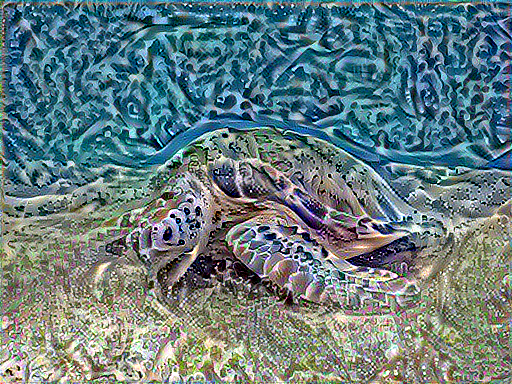

Iteration: 90
Total loss: 1.8221e+07, style loss: 1.6608e+07, content loss: 1.6124e+06, avg iteration time: 2.7752s
Total time: 282.5264s
Iteration avarage time: 2.8043s
Result:


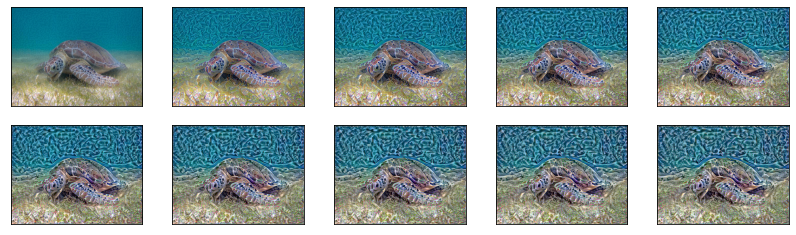

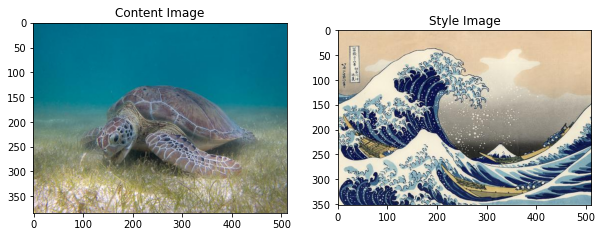

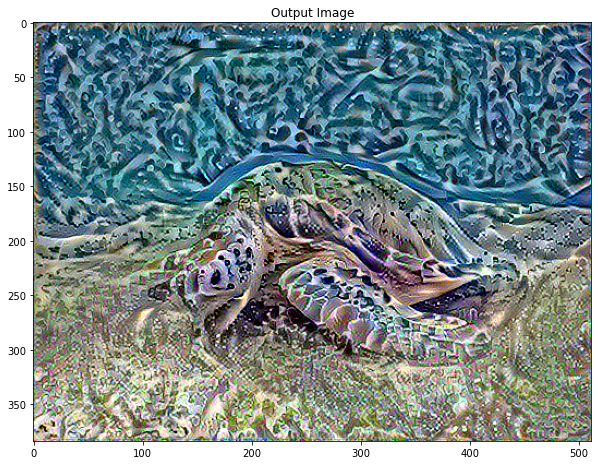

In [18]:
content_path = 'img_dir/oryginal.jpg'
style_path = 'img_dir/art.jpg'

display_content_and_style_img(content_path, style_path)

# start transfer
print("Processing images")
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=iter_num, log_interval=log_int)
                                     
Image.fromarray(best)

# show results
print("Result:")
show_results(best, content_path, style_path)